In [5]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import datetime

In [2]:
train_df = pd.read_csv('train.csv', parse_dates=['date'])
test_df = pd.read_csv('test.csv', parse_dates=['date'])
# all_df = pd.concat([a_df, b_df]).reset_index()

In [3]:
result_df = pd.read_csv('result_df', parse_dates= ['date'])


In [13]:
def create_plot(database, group, filter):
    CV_grouped = database[database['date'] > '2017-07-31']
    CV_grouped = CV_grouped.groupby(by =[group, 'date'])[['sales']].sum().loc[filter]
    
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(CV_grouped.index, CV_grouped['sales'], label = 'actual')
    ax.set_title('CV_plot')
    ax.legend()
    ax.tick_params(axis='x', rotation=90)

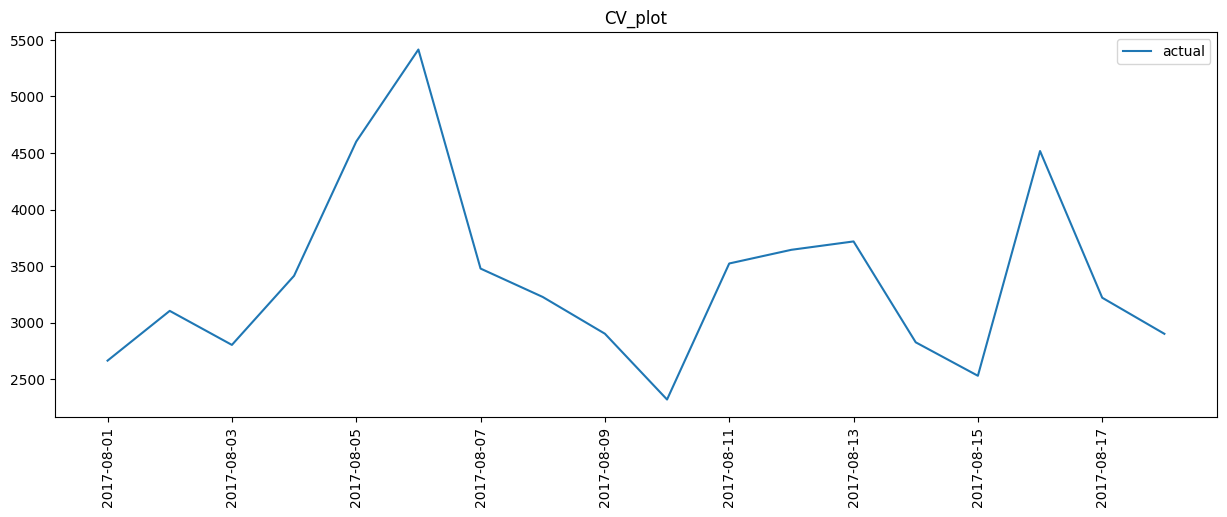

In [27]:
create_plot(result_df, 'family', 'SCHOOL AND OFFICE SUPPLIES')

In [5]:
result_df.drop(columns ='Unnamed: 0.1', inplace= True)

In [7]:
result_df.columns

Index(['Unnamed: 0', 'id', 'date', 'store_nbr', 'family', 'sales',
       'onpromotion'],
      dtype='object')

In [8]:
test_df_add = test_df[test_df['date']  == '2017-08-18']
all_df = pd.concat([result_df, test_df_add]).reset_index()

In [ ]:
all_df.tail()

,index,id,date,store_nbr,family,sales,onpromotion
3006229,5341,3006229,2017-08-18,9,POULTRY,NaN,14
3006230,5342,3006230,2017-08-18,9,PREPARED FOODS,NaN,2
3006231,5343,3006231,2017-08-18,9,PRODUCE,NaN,1
3006232,5344,3006232,2017-08-18,9,SCHOOL AND OFFICE SUPPLIES,NaN,6
3006233,5345,3006233,2017-08-18,9,SEAFOOD,NaN,0


In [10]:
all_df.drop(columns =['index'], inplace= True)

In [11]:
all_df.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')

In [12]:
all_df.sort_values(by = ['store_nbr', 'family'], inplace = True)

# dropping days with zero sales (the ones zero from 2013-01-01) - store opened later
all_df.drop(index = all_df[(all_df['store_nbr'] == 20) & (all_df['date'] < '2015-02-13')].index, inplace = True)
all_df.drop(index = all_df[(all_df['store_nbr'] == 21) & (all_df['date'] < '2015-07-24')].index, inplace = True)
all_df.drop(index = all_df[(all_df['store_nbr'] == 22) & (all_df['date'] < '2015-10-09')].index, inplace = True)
all_df.drop(index = all_df[(all_df['store_nbr'] == 29) & (all_df['date'] < '2015-03-20')].index, inplace = True)
all_df.drop(index = all_df[(all_df['store_nbr'] == 36) & (all_df['date'] < '2013-05-09')].index, inplace = True)
all_df.drop(index = all_df[(all_df['store_nbr'] == 42) & (all_df['date'] < '2015-08-21')].index, inplace = True)
all_df.drop(index = all_df[(all_df['store_nbr'] == 52) & (all_df['date'] < '2017-04-20')].index, inplace = True)
all_df.drop(index = all_df[(all_df['store_nbr'] == 53) & (all_df['date'] < '2015-05-29')].index, inplace = True)

store_df =pd.read_csv('stores.csv')
holiday_df = pd.read_csv('holidays_events.csv', parse_dates= ['date'] )
holiday_df['weekday'] = [n.isoweekday() for n in holiday_df['date']]

all_df['weekday'] = all_df['date'].apply(lambda x: x.isoweekday())
all_df['month'] = all_df['date'].apply(lambda x: str(x.month).zfill(2)) # zero padding to two digits
all_df['year'] = all_df['date'].apply(lambda x: str(x.year))
all_df['year_month'] = all_df['year'] + '_' + all_df['month']

all_df = pd.merge(all_df, store_df, how = 'left', on = 'store_nbr')

prod_list = list(all_df.family.unique())
store_list = list(store_df.store_nbr.unique())

In [13]:
## adding features
# adding time
complete_date_range = pd.DataFrame()
complete_date_range['date'] = pd.date_range(start=all_df['date'].min(), end=all_df['date'].max(),freq='D')
complete_date_range['time'] = complete_date_range.index
all_df = pd.merge(all_df, complete_date_range, how = 'left', on ='date')

# adding lag
def lag(feature, length):
    final_series = pd.Series()
    for f in all_df[ 'family' ].unique():
        filtered = all_df.loc[all_df[ 'family' ] == f]
        for nr in all_df[ 'store_nbr' ].unique():
            filtered2 = filtered.loc[all_df[ 'store_nbr' ] == nr]
            lagged_series = filtered2[ feature ].shift(length)  
            final_series = pd.concat([final_series, lagged_series])
    all_df[f'lag_{feature}_{length}'] = final_series

lag('sales', 1)
lag('sales', 7)
lag('sales', 14)
lag_with_na = [n for n in all_df.columns if n.startswith('lag')]
all_df.dropna(subset= lag_with_na, inplace= True)

# adding days
def add_days(database):
    database['weekday'] = [n.isoweekday() for n in database['date']]
    database = pd.get_dummies(database, columns=['weekday'])
    return database
all_df = add_days(all_df)


In [14]:
# adding national holidays
national = holiday_df[ (holiday_df['locale'] == 'National')&(holiday_df['transferred'] == False)]
all_df = pd.merge(all_df, national[['date', 'transferred']], on = 'date', how = 'left')
all_df = all_df.rename( columns={ 'transferred' : 'holiday'})
all_df['holiday'] = np.where(all_df['holiday'] == False, True, False)

In [60]:
# train_df = all_df[all_df['date'] < '2017-08-16']
# test_df = all_df[all_df['date'] > '2017-08-15']

In [15]:
all_df.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'month',
       'year', 'year_month', 'city', 'state', 'type', 'cluster', 'time',
       'lag_sales_1', 'lag_sales_7', 'lag_sales_14', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7',
       'holiday'],
      dtype='object')

In [19]:
def run_rgr_date(*args, date = '2017-08-16'):
    arg_list = list(args)
    pred_test_acc = np.empty((0,1))

    for nr in store_list:
        filtered = all_df.loc[all_df['store_nbr'] == nr]
        for f in prod_list:
            filtered_2 = filtered.loc[all_df[ 'family' ] == f]
     
            X_test = filtered_2.loc[filtered_2['date'] == date, arg_list]
            if X_test.shape ==  (0, len(args)):
                continue

            CV_index_dropped = filtered_2.drop(index = X_test.index)
            X_train = CV_index_dropped[arg_list].values
            y_train = CV_index_dropped['sales'].values.reshape(-1, 1)
            
            X_test = X_test.values    
            
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_test  = scaler.transform(X_test)

            rgr = linear_model.LinearRegression()
            rgr.fit(X_train, y_train)
            pred_test = rgr.predict(X_test)

            pred_test_acc = np.concatenate((pred_test_acc, pred_test)).reshape(-1, 1)     

    # not allowing negative amounts in the prediction
    pred_test_acc[pred_test_acc < 0] = 0

    return pred_test_acc

In [20]:
x = run_rgr_date('time', 'lag_sales_1', 'lag_sales_7', 'lag_sales_14',  'onpromotion',
                  'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',  'weekday_6', 'weekday_7', 'holiday',  date = '2017-08-18')

In [21]:
len(x)

1782

In [22]:
day = all_df[all_df['date'] == '2017-08-18']
len(day)

1782

In [23]:
day['sales'] = x

C:\Users\bokuhu01\AppData\Local\Temp\1\ipykernel_16996\3601087894.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day['sales'] = x


In [25]:
result_df.tail()

,id,date,store_nbr,family,sales,onpromotion
3004447,3004315,2017-08-17,54,POULTRY,52.477292,0
3004448,3004316,2017-08-17,54,PREPARED FOODS,75.861992,0
3004449,3004317,2017-08-17,54,PRODUCE,862.648793,0
3004450,3004318,2017-08-17,54,SCHOOL AND OFFICE SUPPLIES,8.319032,0
3004451,3004319,2017-08-17,54,SEAFOOD,2.044672,0


In [26]:
result_df = pd.concat([result_df, day[['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion']]])

In [27]:
len(result_df)

3006234

In [28]:
result_df.to_csv('result_df')

In [29]:
result_df.tail()

,id,date,store_nbr,family,sales,onpromotion
2748791,3006097,2017-08-18,54,POULTRY,68.969839,5
2750468,3006098,2017-08-18,54,PREPARED FOODS,73.573133,0
2752145,3006099,2017-08-18,54,PRODUCE,718.311757,2
2753822,3006100,2017-08-18,54,SCHOOL AND OFFICE SUPPLIES,2.197692,0
2755499,3006101,2017-08-18,54,SEAFOOD,0.967906,0
